In [1]:
import ArticleComparator as ac
from bs4 import BeautifulSoup
import csv 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from Helper import *
from Helper import update_links_df_position

sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")

from graph import Graph

In [2]:
truth_graph = Graph()
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
truth_graph.update_graph("data/links.tsv", mode='g', verbose=False)

In [3]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=False) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=False) 

---
---

### 4. The Influence of the article topology on human behavior:

In this section, we will try to understand the influence of the article topology on human behavior. We will try to answer the following questions: <br>

1. How does the click rate on a link evolve with is position in the article?<br>

2. How does the proportion of clicked links evolve with number of exiting links in an article? <br>

Both our tasks need informations about the position of the links in each article. To do so let's first create a new data frame, the `links_df` that contains all the exiting links in an article and the number of exiting links in an article. <br>
This dataframe will contain the following columns: <br>
- `From`: the article from which the link is outgoing <br>
- `To`: the article to which the link is incomming <br>
- `positions`: the positions at whitch the `To` artical appears in the `From` article <br>
- `n_links`: The total number of exiting links in the `From` article <br>

First we fetch all the links from the `links.tsv` file in order to initialize `From` and `To` entries. <br>

In [4]:
links_df = create_links_df()
links_df.sample(5)

,From,To
86798,Poland,Napoleon_I_of_France
23591,Chinese_language,Arabic_language
116582,Westminster_Abbey,Stratford-upon-Avon
101073,Space_Shuttle_Columbia_disaster,Earth%27s_atmosphere
114311,Vinaya,Buddhism


Then we retreive the `positions` of each link is each article using the `.html` files. We do so because it is the only to find them in **the order of apparition in each article**. <br> In this task we use the `BeautifulSoup` library to parse the `.html` files. <br>
Finally we add the `n_links` column to the dataframe. <br>

In [5]:
update_links_df_position(links_df, truth_graph)

In [6]:
# drop nan values
links_df.dropna(inplace=True)
# nb_links column contains only int values
links_df['nb_links'] = links_df['nb_links'].astype(int)
links_df.sample(5)

,From,To,positions,nb_links
19164,Burkina_Faso,AIDS,[39],43
86889,Police,Max_Weber,[14],73
11871,Baby_Gender_Mentor,China,[5],8
102891,Stuttering,England,[19],30
114429,Virus,AIDS,"[5, 23]",37


Now that our dataframe is ready, we can start answering our questions.

#### 4.1. How does the click rate on a link evolve with is position in the article?

The weight is the adjacency matrix of our commun sense graph is our metric for the click rate.  <br>
Thus we add a new column to the links_df dataframe that contains the `weight` of each link. <br>

In [7]:
update_link_df_weights(links_df, cs_graph)
print("Number of links in the dataframe: ", len(links_df))
links_df.sample(5)

Number of links in the dataframe:  119879


,From,To,positions,nb_links,weight
58473,Jersey_Zoological_Park,Chimpanzee,[11],12,0
39101,Fertile_Crescent,Cattle,[28],32,2
69726,Margaret_Thatcher,Chemistry,[9],96,1
31266,Djibouti,United_States,[17],359,2
103954,Super_Chief,San_Diegan,[7],17,0


Since we want to investigate the effect of the weight on the position of the link, we will keep only the links that have a unique occurence in the article to avoid any bias. <br>

In [31]:
# keep only the positions that are arrays
filtred_links_df = links_df[links_df['positions'].apply(lambda x: isinstance(x, list))]
# keep only the positions that are arrays of length 1
filtred_links_df = filtred_links_df[filtred_links_df['positions'].apply(lambda x: len(x)==1)]
# store positions as int
filtred_links_df['positions'] = filtred_links_df['positions'].apply(lambda x: int(x[0]))
# Add a column with relative position which is position/nb_links
filtred_links_df['relative_position'] = filtred_links_df.apply(lambda row: round(row['positions']/row['nb_links'],2)*100, axis=1)

In [32]:
print("Number of links in the dataframe after filtering non unique links: ", len(filtred_links_df))
filtred_links_df.sample(5)

Number of links in the dataframe after filtering non unique links:  89080


,From,To,positions,nb_links,weight,relative_position
11048,Australian_Ringneck,Chordate,2,7,0,29.0
119310,Zambezi,Bull_shark,47,59,0,80.0
51241,History_of_slavery,British_Empire,60,97,0,62.0
23941,Christmas_Island,China,12,39,0,31.0
104962,Taipei,Mbabane,54,66,0,82.0


We plot the average weight for each relative position without duplicates in the CS graph.

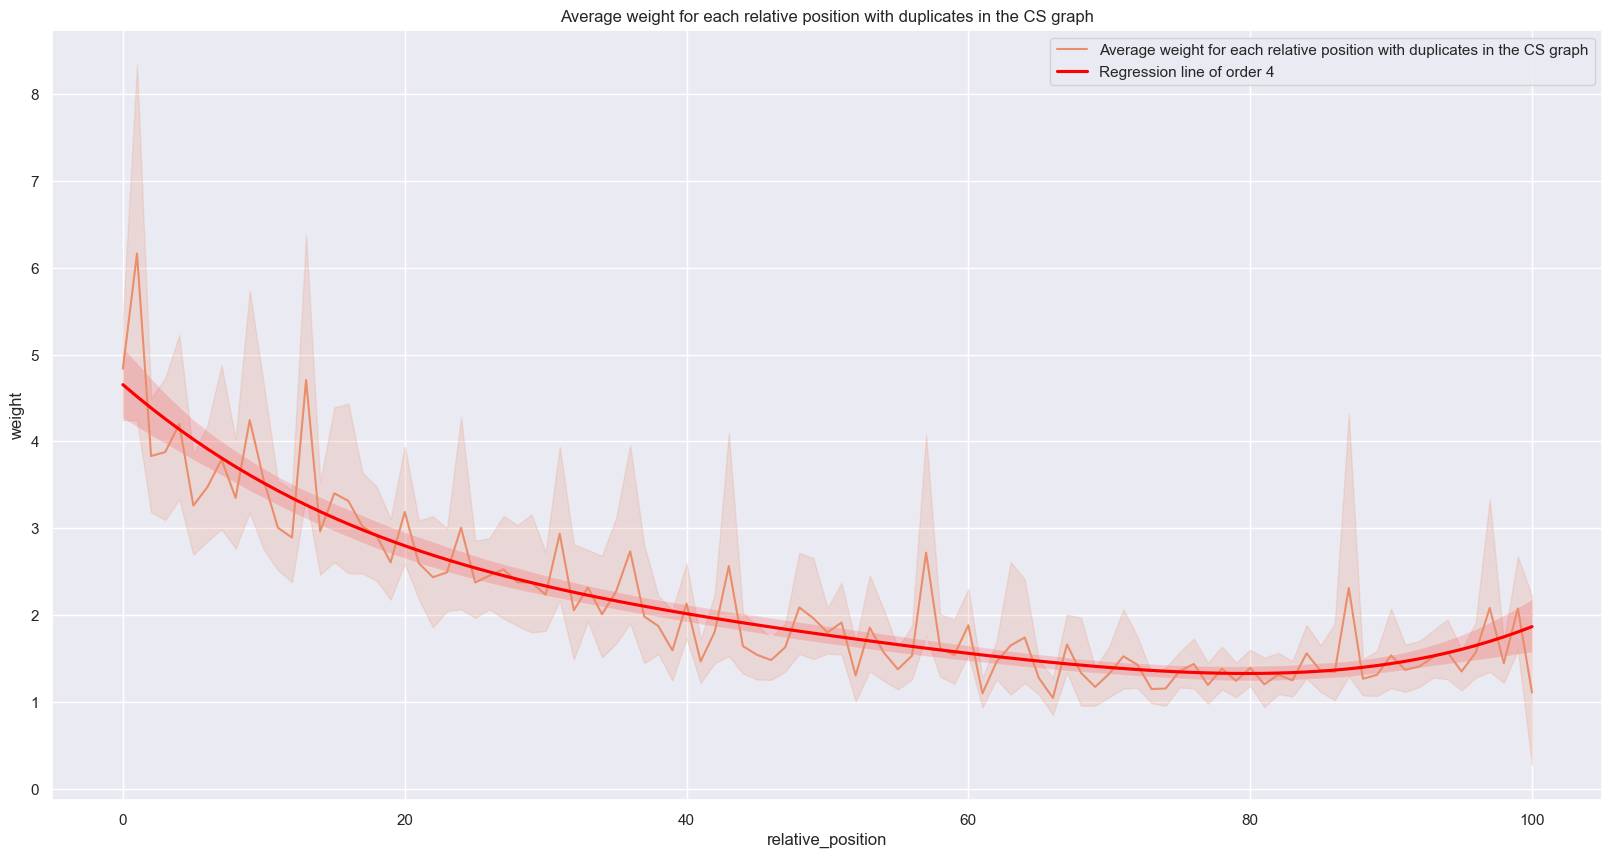

In [36]:
# plot average weight for each relative_position_duplicates
plt.figure(figsize=(20,10))
# Plot the average weight for each relative position without duplicates in the CS graph
sns.lineplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, label="Average weight for each relative position with duplicates in the CS graph",legend='full', errorbar=('ci', 95) )
# Add regression line
sns.regplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, scatter=False, color="red", label="Regression line of order 4", order= 4)
# legend for ci 
plt.legend(loc='upper right')
plt.title("Average weight for each relative position with duplicates in the CS graph")
plt.show()

We can clearly see a downtrend of the weight as a function of the relative position of the link inside the articles.<br>

Links at the beginning of the article are **3 times** more likely to be clicked on than links at later stage of the article : The average weight of a link at around the 1st percentage of the article $\simeq 4,5$ , while it is $\simeq 1,5$ at 80% of the article. <br>
&rarr; This means that links in the beginning of the article are more likely to be clicked on. <br>

This clearly shows that the relative position of the link in the article is determinant on whether the user will click on it or not.



# TODO : add legend ?

#### 2. How does the proportion of clicked links evolve with number of exiting links in an article? <br>

Let's get back to our `links_df` dataframe. <br>

In [37]:
links_df.sample(5)

,From,To,positions,nb_links,weight
109476,Tower_Bridge,Steam_engine,[12],17,1
94875,Saladin,Walter_Scott,[23],31,0
96782,Sculpture,Poland,[24],32,1
1078,1st_century,6th_century,[24],40,0
61130,King_Kong_%282005_film%29,Sumatra,[5],16,0
